# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr

import yfinance as yf
from datetime import datetime

from utils import set_size, plot_cumulative_returns_and_weights

In [2]:
###Save mode
save_mode = False

In [3]:
#set color palette
sns.set_palette('Set2')
#set plot font sizes
plt.rcParams.update({
    'font.size': 11,
    })


import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

### Select the tickers and timeframe

In [4]:
lookback = 60
#try to open file from path
tickers = ["MSFT", "NVDA", "PFE", "GS", "SBUX", "CAT", "XOM", "PG"]
vix = ["^VIX"]
start_date = "2013-08-01"
end_date = "2023-12-31"
#define path with start and end date in file name
path = 'stock_data_' + start_date + '_' + end_date + '.csv'
try:
    data = pd.read_csv(path, index_col=0, parse_dates=True)
    print("File opened successfully")
except:
    print("File not found, downloading data from Yahoo Finance")
    #download data from yahoo finance
    
    df = pdr.get_data_yahoo([tickers + vix][0], start=start_date, end=end_date)
    data = df.copy()
    # we copy the neighbour values to NaN entries
    data['Adj Close'] = data['Adj Close'].ffill()
    df = df.bfill(axis=1)
    data['Adj Close'] = data['Adj Close'].bfill()
    df = df.bfill(axis=1)
    data = data['Adj Close']
    data = data[tickers + vix]
    #find index of 2014-01-01
    index = data.index.get_loc('2014-01-02')
    #cut data before index
    data = data.iloc[index-lookback+1:]
    #save data to csv
    data.to_csv(path)

File opened successfully


### Define the start-end dates for the training and testing data

In [5]:
train_pct = 0.8
samples_train = int(train_pct*(len(data)) + 0.2*(lookback-1)) 
data_train = data[:samples_train]
data_test = data[samples_train:]
data_test_2 = data[samples_train-lookback+1:]

data_train_VIX = data_train['^VIX']
data_test_VIX = data_test_2['^VIX']

data_train = data_train[tickers]
data_test = data_test[tickers]
data_test_2 = data_test_2[tickers]

### Visualization

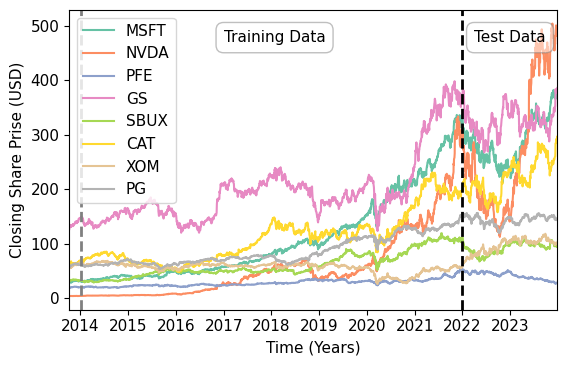

In [6]:
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
for i in tickers:
    ax.plot(data[i], label=i)

# only one line may be specified; full height
ax.axvline(pd.to_datetime('2021-12-29'), color='black', linestyle='--', lw=2)
ax.axvline(pd.to_datetime('2014-01-02'), color='grey', linestyle='--', lw=2)
ax.legend()
ax.margins(x=0)
ax.set_ylabel("Closing Share Prise (USD)")
ax.set_xlabel("Time (Years)")
#textbox for training and test data
ax.text(pd.to_datetime('2017-01-01'), 470, 'Training Data',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey', boxstyle='round,pad=0.5'))
ax.text(pd.to_datetime('2022-04-01'), 470, 'Test Data',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey', boxstyle='round,pad=0.5'))

plt.show()


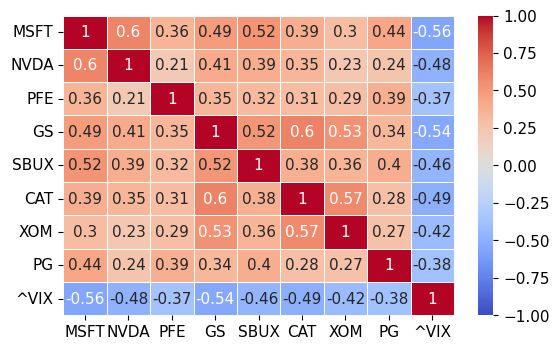

In [7]:
#calculate the daily returns
returns = data.pct_change()
#correlation matrix of stock returns keep the order of tickers
corr_matrix = returns.corr()
#plot as seaborn heatmap
plt.figure(figsize=(set_size('thesis', fraction=1)))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
#set yticks to avoid cutting off the first and last tick
plt.yticks(rotation=0)

plt.show()

# Deep Reinfrocement Learning

In [8]:
#from DRL_Port import StockEnvTrade, train, DRL_prediction
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

from Portfolio_DRL import PortEnv_S1, SharpeEnv_S1, PortEnv_S2, SharpeEnv_S2, train, DRL_prediction, linear_decay_schedule


**General Hyperparameter**
- Number of time steps -> 200_000 (= 100 episodes x ~2_000 training days)
- Mlp Policy -> flat action space

In [9]:
lookback = 60 #lookback period for the complex model and traditional model

runs = 2 #number of runs for each model

timesteps = 20_000 #number of total timesteps for each training
policy = "MlpPolicy" #policy for the model

ppo_hyperparams = {
    "learning_rate": linear_decay_schedule(3e-4, 1e-5),
    "batch_size": 128,
    "gamma": 0.95,
    "gae_lambda": 0.9,
    "clip_range": 0.2,
    "ent_coef": 0.01
}

a2c_hyperparams = {
    "learning_rate": linear_decay_schedule(3e-4, 1e-5),
    "batch_size": 128,
    "gamma": 0.95,
    "ent_coef": 0.01
}

sac_hyperparams = {
    "learning_rate": linear_decay_schedule(3e-4, 1e-5),
    "gamma": 0.95,
    "gae_lambda": 0.9,
}

test_re_df = data_test.copy() #test data for the models (same for each model)

length = test_re_df.shape[0] #length of the test data (trading days)
stocks = test_re_df.shape[1] #number of stocks

index = test_re_df.index #dates of the test data as array

return_stocks = test_re_df.pct_change() #calculate the daily returns of the test data

### 1. Portfolio reward with simple state

In [10]:
train_re_df = data_train.iloc[lookback-1:, :] #training data for the models (depends on state)

**Check if environment work** 

In [11]:
validate_env = PortEnv_S1(df=train_re_df)
try:
    check_env(validate_env, warn=True)
    print("Environment is OK")
except:
    print("Environment has issuses")
    # show the error message
    check_env(validate_env, warn=True)

obs, _ = validate_env.reset()

validate_env.render()

print(validate_env.observation_space)
print(validate_env.action_space)
print(validate_env.action_space.sample())

Environment is OK
Box(0.0, inf, (17,), float32)
Box(-1.0, 1.0, (8,), float32)
[ 0.33452982 -0.29666516 -0.5857042  -0.6097009   0.7291731  -0.96282613
  0.00572687  0.5709723 ]


### 1.1 PPO

In [12]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo_1_1 = np.zeros([runs, length])
portfolio_weights_ppo_1_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=ppo_hyperparams)

    test_env = DummyVecEnv([lambda: PortEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ppo_1_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ppo_1_1[i])
    print(check)

    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_1_1[i]),axis=1)
    Cumulative_returns_daily_drl_ppo_1_1[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  0.4548352082570394  minutes
504.0
Training time:  0.44114083449045816  minutes
504.0


In [13]:
model.policy #print the policy network of the PPO model

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=8, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

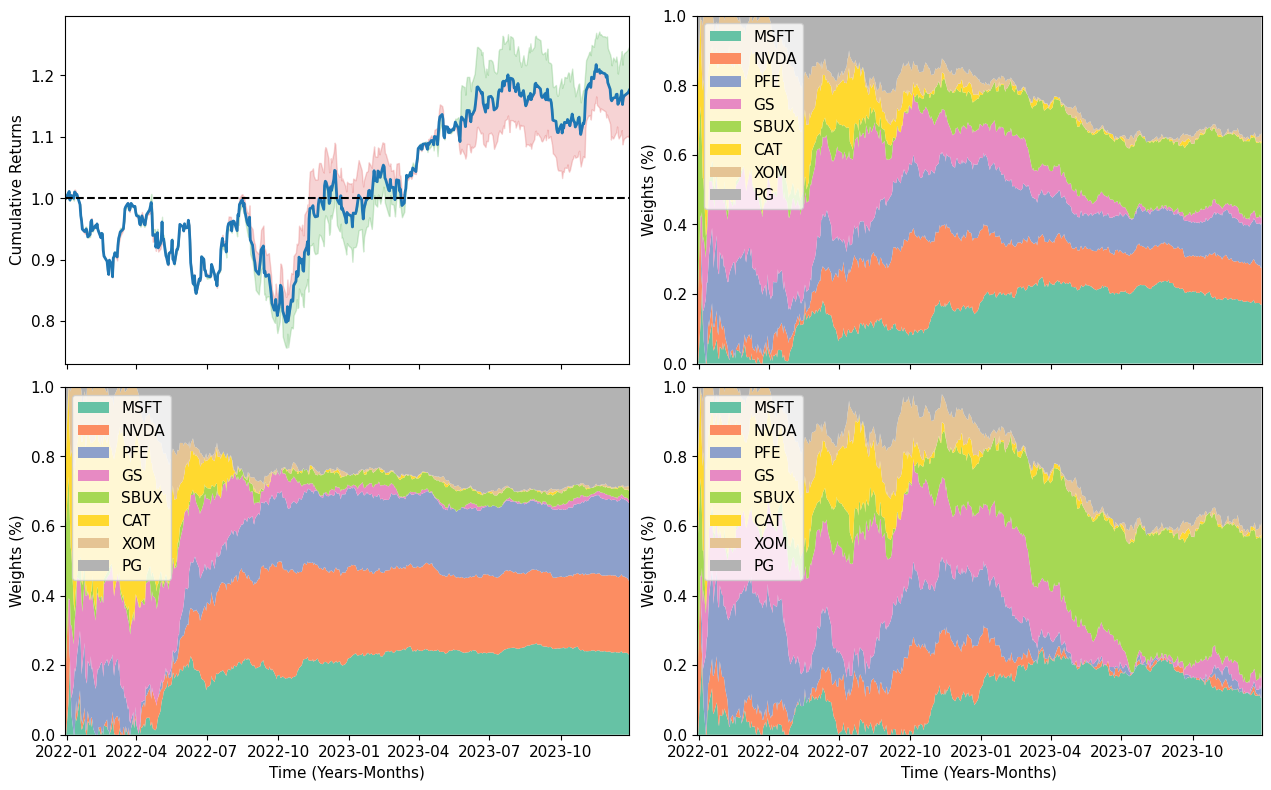

In [14]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_ppo_1_1, portfolio_weights_ppo_1_1, index, tickers)

### 1.2 A2C 

In [15]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c_1_1 = np.zeros([runs, length])
portfolio_weights_a2c_1_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=a2c_hyperparams)

    test_env = DummyVecEnv([lambda: PortEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_a2c_1_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_a2c_1_1[i])
    print(check)

    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_1_1[i]),axis=1)
    Cumulative_returns_daily_drl_a2c_1_1[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  0.4622039715449015  minutes
504.0
Training time:  0.4537810246149699  minutes
504.0


In [16]:
model.policy #print the policy network of the A2C model

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=8, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

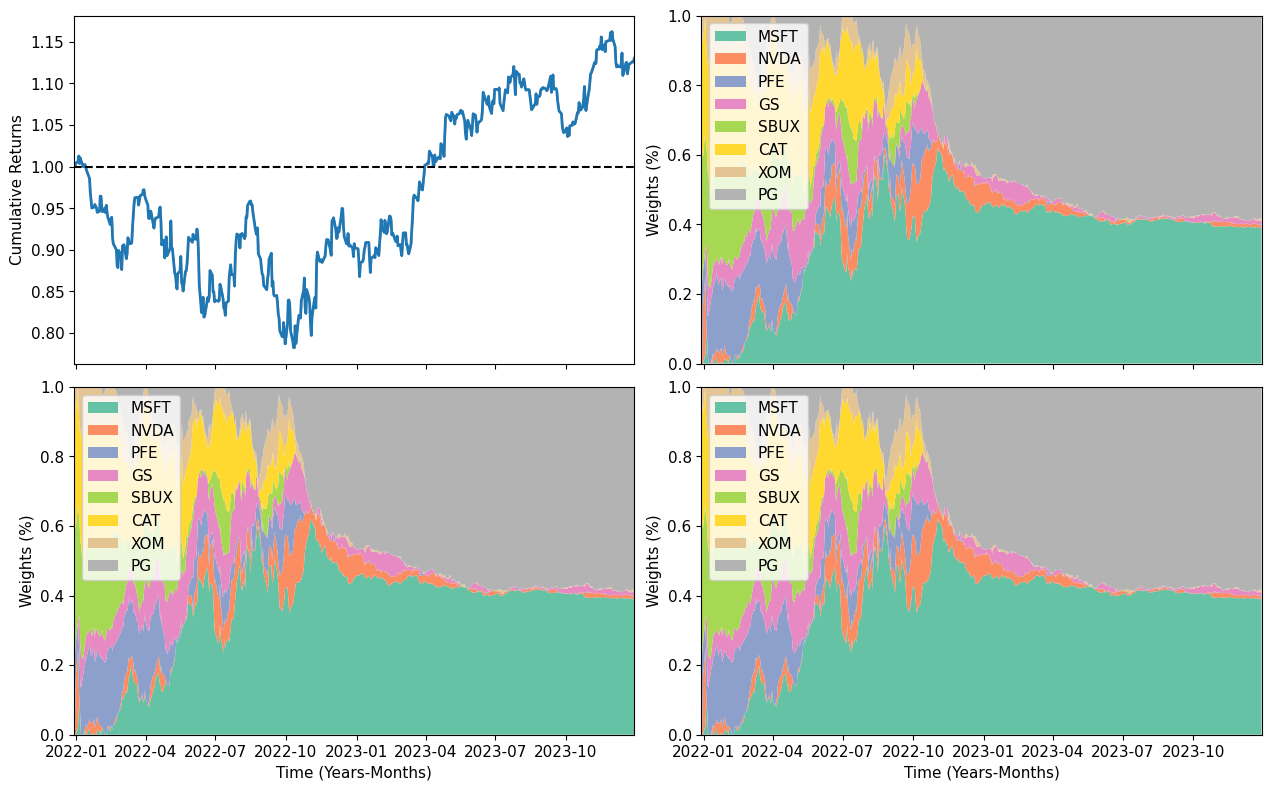

In [17]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_a2c_1_1, portfolio_weights_a2c_1_1, index, tickers)

### 1.3 SAC

In [18]:
algo = "SAC"
Cumulative_returns_daily_drl_sac_1_1 = np.zeros([runs, length])
portfolio_weights_sac_1_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False)

    test_env = DummyVecEnv([lambda: PortEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_sac_1_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_sac_1_1[i])
    print(check)

    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_1_1[i]),axis=1)
    Cumulative_returns_daily_drl_sac_1_1[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  6.791697112719218  minutes
503.9999999999999
Training time:  6.73349312543869  minutes
504.0


In [19]:
model.policy #print the policy network of the SAC model

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=17, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=8, bias=True)
    (log_std): Linear(in_features=256, out_features=8, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=25, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=25, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, b

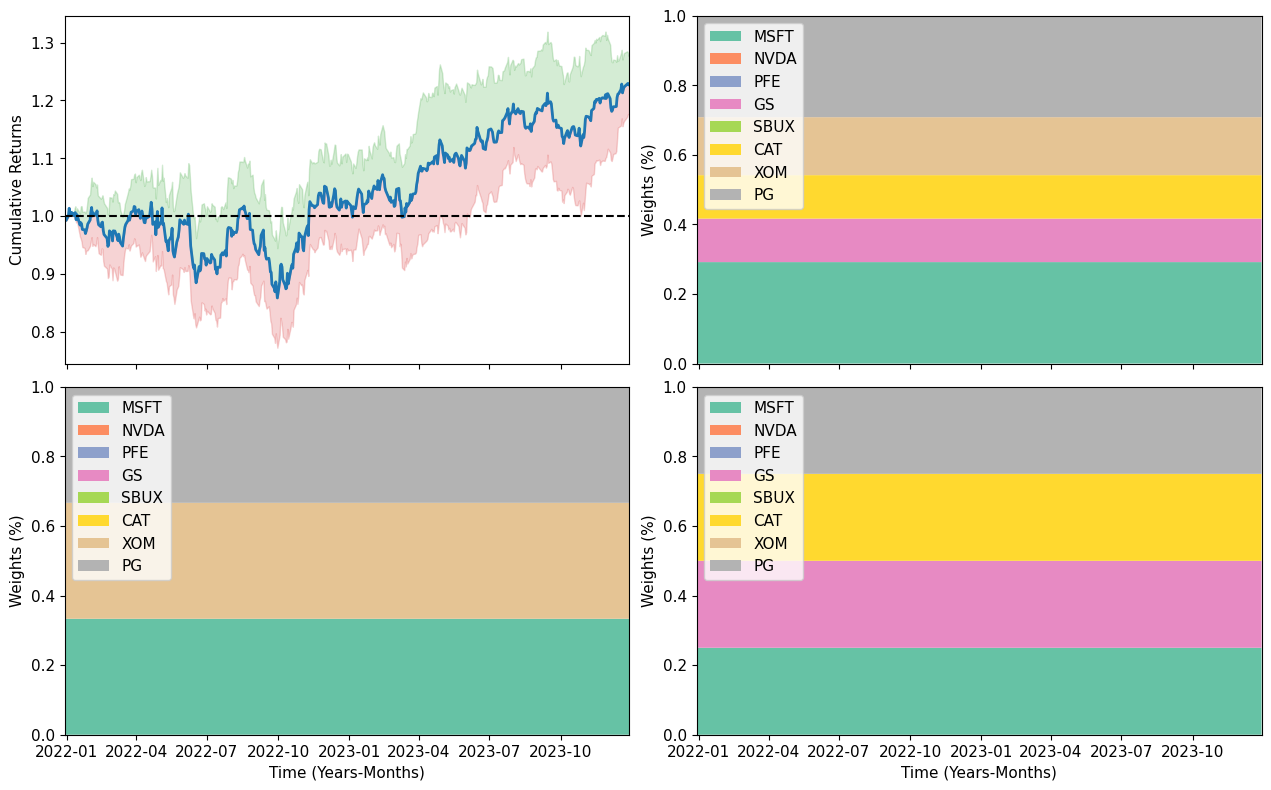

In [20]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_sac_1_1, portfolio_weights_sac_1_1, index, tickers)

### 2. Sharpe reward with simple state

In [21]:
validate_env = SharpeEnv_S1(df=train_re_df)
try:
    check_env(validate_env, warn=True)
    print("Environment is OK")
except:
    print("Environment has issuses")
    # show the error message
    check_env(validate_env, warn=True)

obs, _ = validate_env.reset()

validate_env.render()

print(validate_env.observation_space)
print(validate_env.action_space)
print(validate_env.action_space.sample())

Environment is OK
Box(0.0, inf, (17,), float32)
Box(-1.0, 1.0, (8,), float32)
[-0.34907067  0.50737756  0.9802469  -0.9466916   0.21021086  0.5195917
  0.98544836 -0.71174574]


### 2.1 PPO

In [22]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo_1_2 = np.zeros([runs, length])
portfolio_weights_ppo_1_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=ppo_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ppo_1_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ppo_1_2[i])
    print(check)

    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_1_2[i]),axis=1)
    Cumulative_returns_daily_drl_ppo_1_2[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  0.44549129009246824  minutes
504.0
Training time:  0.3861852526664734  minutes
504.0


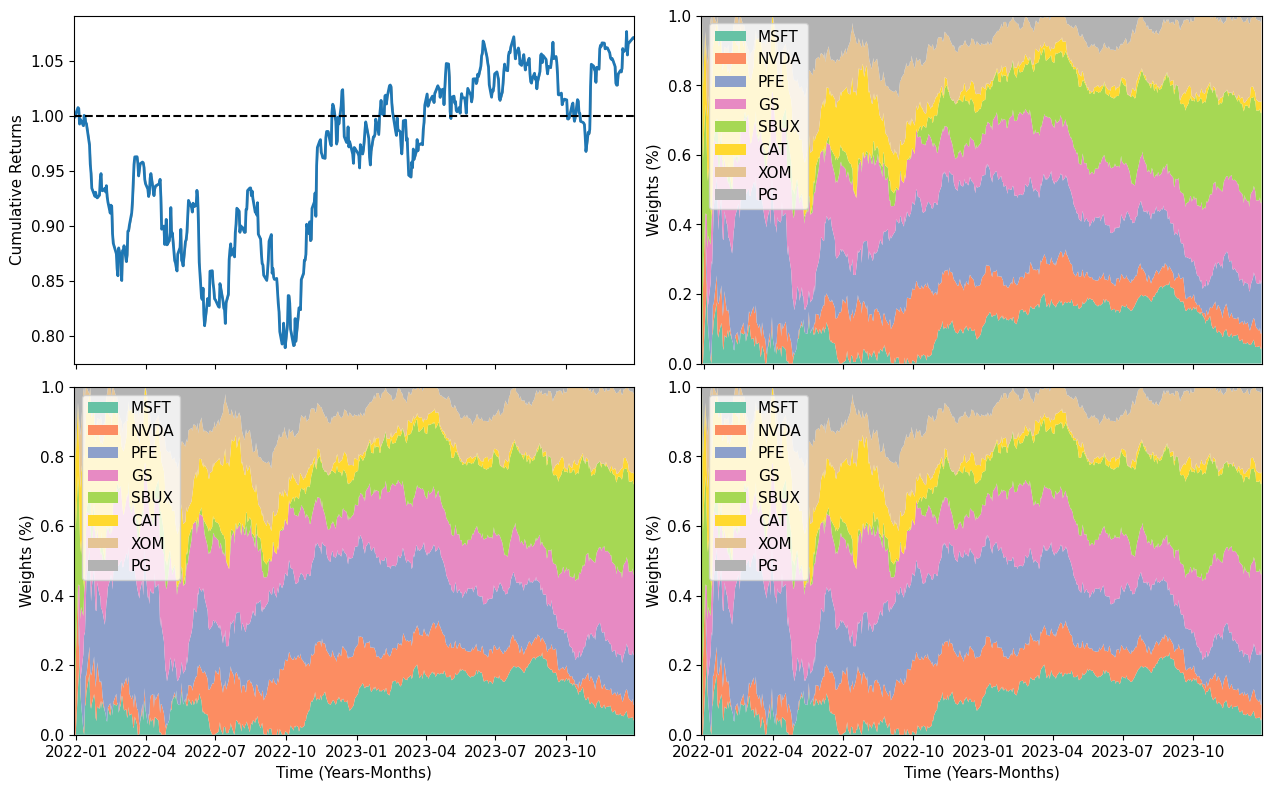

In [23]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_ppo_1_2, portfolio_weights_ppo_1_2, index, tickers)

### 2.2 A2C

In [24]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c_1_2 = np.zeros([runs, length])
portfolio_weights_a2c_1_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=a2c_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_a2c_1_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_a2c_1_2[i])
    print(check)

    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_1_2[i]),axis=1)
    Cumulative_returns_daily_drl_a2c_1_2[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  0.4366649587949117  minutes
504.0
Training time:  0.4326305627822876  minutes
504.0


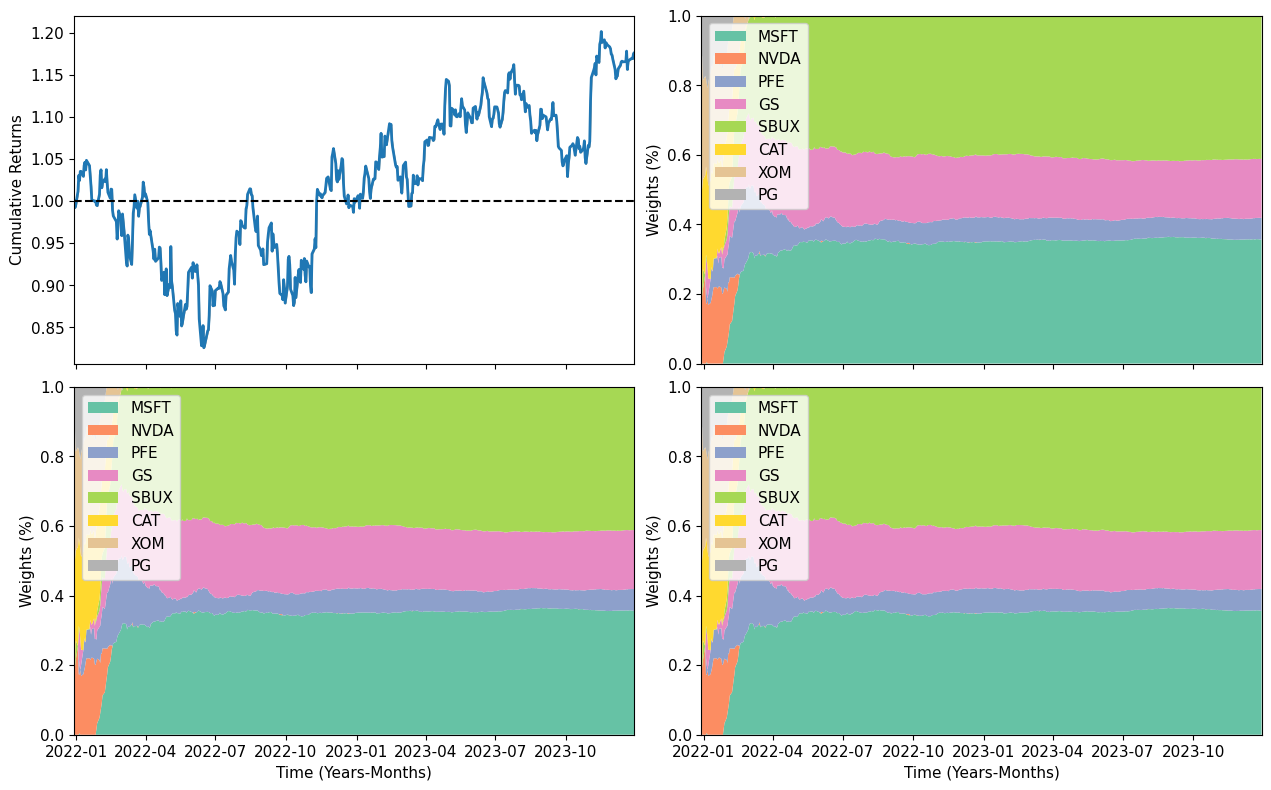

In [25]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_a2c_1_2, portfolio_weights_a2c_1_2, index, tickers)

### 2.3 SAC

In [26]:
algo = "SAC"
Cumulative_returns_daily_drl_sac_1_2 = np.zeros([runs, length])
portfolio_weights_sac_1_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S1(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=sac_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S1(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_sac_1_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_sac_1_2[i])
    print(check)

    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_1_2[i]),axis=1)
    Cumulative_returns_daily_drl_sac_1_2[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  6.743566290537516  minutes
503.9999999999999
Training time:  7.010917309919993  minutes
504.0


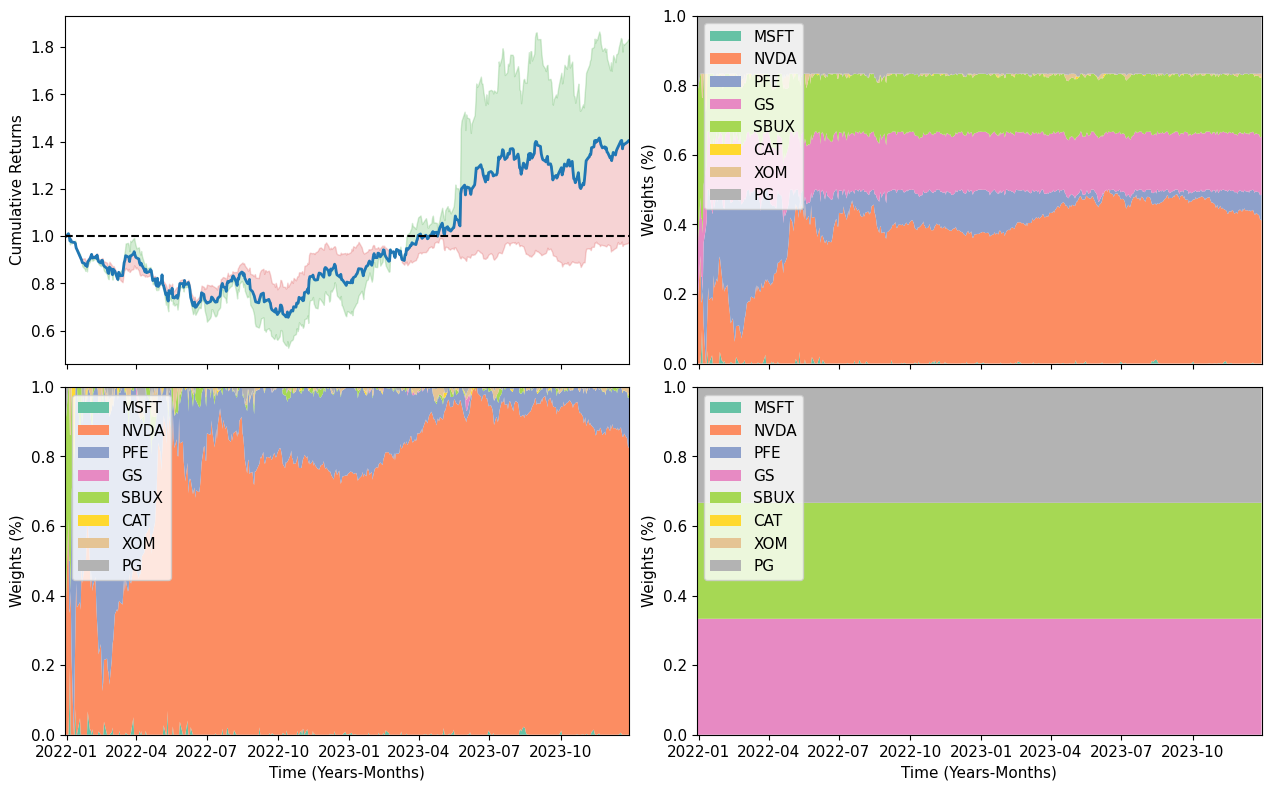

In [27]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_sac_1_2, portfolio_weights_sac_1_2, index, tickers)

### 3. Portfolio reward with complex state

In [28]:
train_re_df = data_train.copy() #training data for the models (depends on state)

test_re_df = data_test_2.copy() #test data for the models (depends on state)

In [29]:
train_re_df.shape

(2071, 8)

In [30]:
data_train_VIX.shape

(2071,)

In [31]:
validate_env = PortEnv_S2(df=train_re_df, df_vix = data_train_VIX)
try:
    check_env(validate_env, warn=True)
    print("Environment is OK")
except:
    print("Environment has issuses")
    # show the error message
    check_env(validate_env, warn=True)

obs, _ = validate_env.reset()

validate_env.render()

print(validate_env.observation_space.sample())
print(validate_env.action_space)
print(validate_env.action_space.sample())

Environment is OK
[[ 1.30417645e+00  3.08847249e-01  3.74355167e-02 -1.80544719e-01
  -7.09106445e-01  8.69540349e-02  7.31481433e-01 -6.37160122e-01
   8.93852293e-01  9.55903411e-01 -7.37770081e-01 -6.25253379e-01
  -1.41285837e-01  4.31050986e-01 -8.71358335e-01 -6.73083961e-01
  -9.60194767e-01 -1.27269477e-01  2.82006338e-02  2.23177090e-01
  -8.14486265e-01  7.26614296e-01  8.37366283e-01  5.47821164e-01
   4.12540406e-01 -8.59235585e-01 -5.30872166e-01  2.04326138e-02
   4.16959137e-01 -5.28846800e-01  3.85249108e-01  3.11178356e-01
  -9.70136523e-01 -2.55075067e-01  5.25919020e-01 -1.55081555e-01
   2.64366984e-01 -4.93914396e-01  8.95787001e-01  2.34786585e-01
  -5.49978375e-01 -1.59923777e-01  2.53512144e-01  9.67028588e-02
   1.96586803e-01  4.10196722e-01 -9.17422116e-01  3.68219554e-01
  -5.28149530e-02 -9.62525189e-01 -5.04968822e-01 -7.55089045e-01
   9.80708897e-01  8.13137293e-01  7.88962066e-01 -9.93213505e-02
  -9.36033726e-02  7.44051695e-01  3.63980114e-01 -5.13415

### 3.1 PPO

In [32]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo_2_1 = np.zeros([runs, length])
portfolio_weights_ppo_2_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=ppo_hyperparams)

    test_env = DummyVecEnv([lambda: PortEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_ppo_2_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_ppo_2_1[i])
    print(check)

    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_2_1[i]),axis=1)
    Cumulative_returns_daily_drl_ppo_2_1[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  1.3156245827674866  minutes
504.0
Training time:  1.546881131331126  minutes
504.0


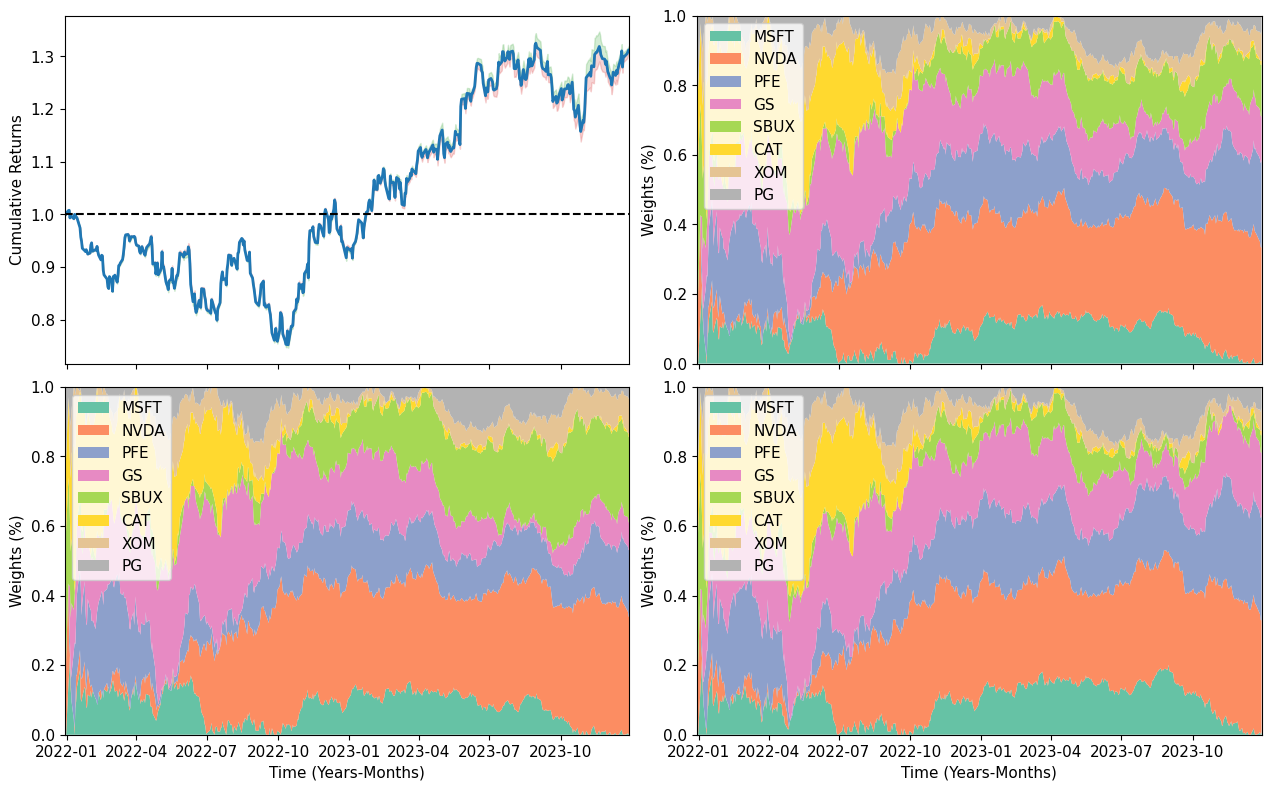

In [33]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_ppo_2_1, portfolio_weights_ppo_2_1, index, tickers)

### 3.2 A2C 

In [35]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c_2_1 = np.zeros([runs, length])
portfolio_weights_a2c_2_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=a2c_hyperparams)

    test_env = DummyVecEnv([lambda: PortEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_a2c_2_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_a2c_2_1[i])
    print(check)

    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_2_1[i]),axis=1)
    Cumulative_returns_daily_drl_a2c_2_1[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  1.5658690412839253  minutes
504.0
Training time:  1.6001980940500895  minutes
504.0


In [36]:
Cumulative_returns_daily_drl_a2c_1_1.shape

(2, 504)

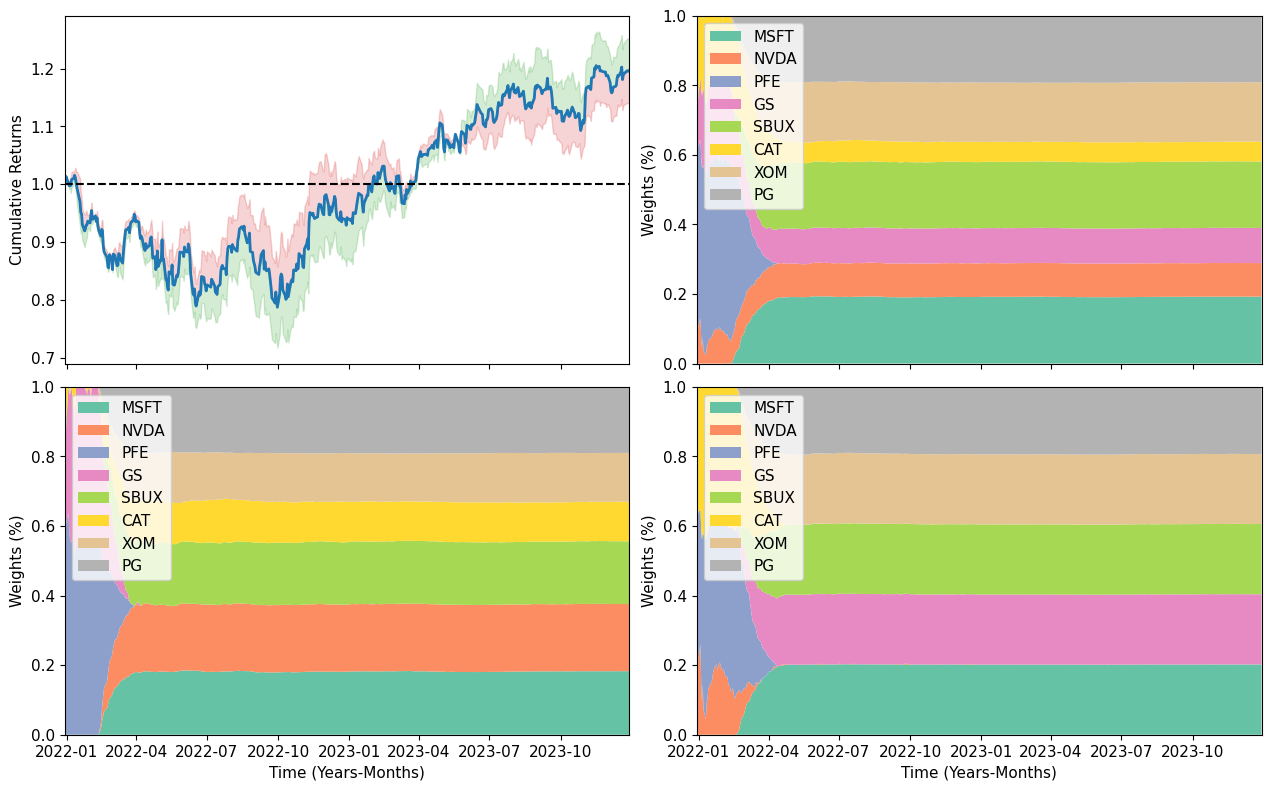

In [37]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_a2c_2_1, portfolio_weights_a2c_2_1, index, tickers)

### 3.3 SAC

In [38]:
algo = "SAC"
Cumulative_returns_daily_drl_sac_2_1 = np.zeros([runs, length])
portfolio_weights_sac_2_1 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: PortEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=sac_hyperparams)

    test_env = DummyVecEnv([lambda: PortEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_sac_2_1[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_sac_2_1[i])
    print(check)

    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_2_1[i]),axis=1)
    Cumulative_returns_daily_drl_sac_2_1[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  15.245768610636393  minutes
504.0
Training time:  15.541920646031697  minutes
504.0


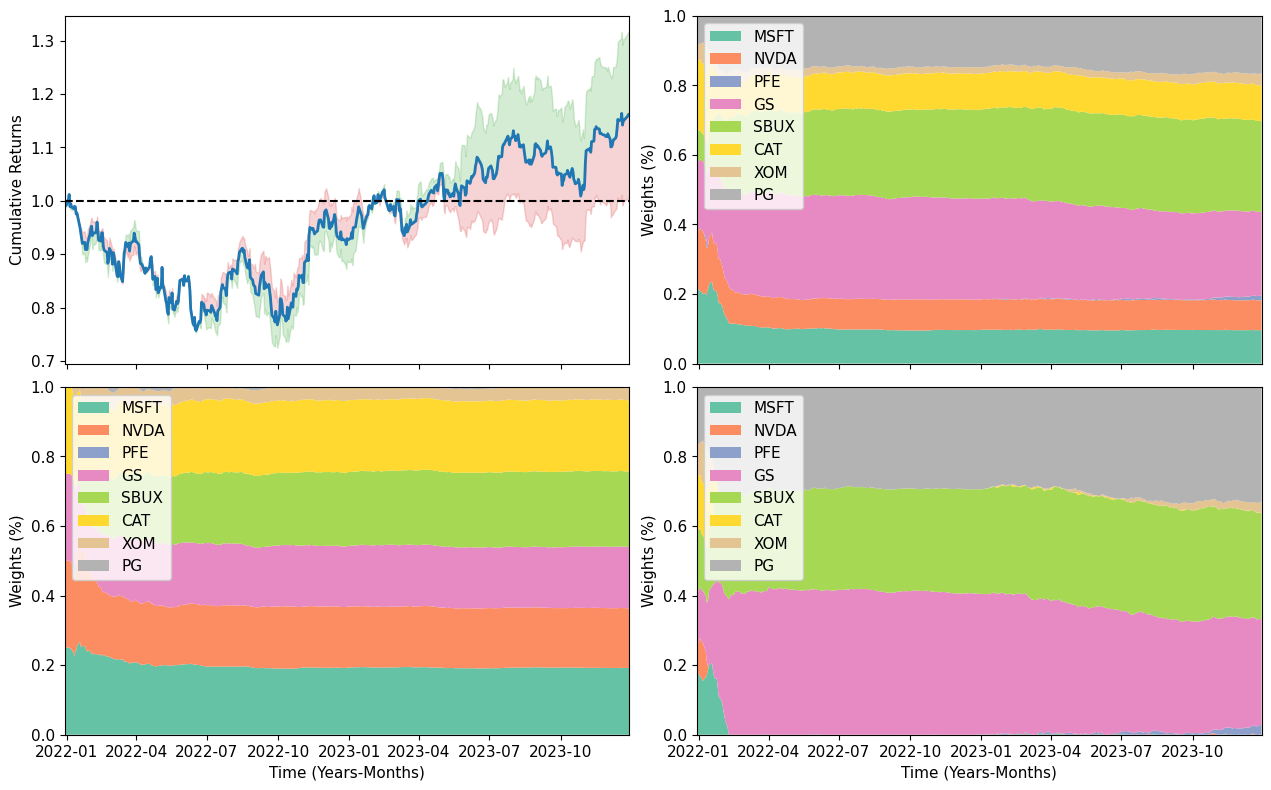

In [39]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_sac_2_1, portfolio_weights_sac_2_1, index, tickers)

### 4. Sharpe reward with complex state

**Reward Function**:
$$
R_t^{(2)} = D_t = \frac{\partial SR_t}{\partial \eta} = \frac{B_{t-1}\Delta A_t-0.5A_{t-1}\Delta B_t}{(B_{t-1}- A_{t-1}^2)^{3/2}}
$$

**State Representation**:
$$
\boldsymbol{S_t}^{(2)} = \begin{bmatrix}
    x_1 & r_{1,t} & \cdots & r_{1,t-T+1} \\
    x_2 & r_{2,t} & \cdots & r_{2,t-T+1} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_l & r_{l,t} & \cdots & r_{l,t-T+1} \\
    V_t & \text{VIX}_t & \cdots & \text{VIX}_{t-T+1} \\
    \end{bmatrix}
$$

In [40]:
train_re_df = data_train.copy() #training data for the models (depends on state)

test_re_df = data_test_2.copy() #test data for the models (depends on state)

In [41]:
validate_env = SharpeEnv_S2(df = train_re_df, df_vix=data_train_VIX)
try:
    check_env(validate_env, warn=True)
    print("Environment is OK")
except:
    print("Environment has issuses")
    # show the error message
    check_env(validate_env, warn=True)

obs, _ = validate_env.reset()

validate_env.render()

print(validate_env.observation_space.sample())
print(validate_env.action_space)
print(validate_env.action_space.sample())

Environment is OK
[[ 1.03945303e+00 -1.02792494e-01  7.25221857e-02 -3.39517176e-01
  -8.26720059e-01 -4.95101601e-01  6.81476444e-02 -3.38137269e-01
   2.61510938e-01  7.66612709e-01  6.31023705e-01  8.59565914e-01
   7.76981354e-01  6.77922845e-01 -1.43619627e-02 -1.58591971e-01
  -1.80877566e-01 -9.78381574e-01  8.34149659e-01  7.77689636e-01
   9.22563612e-01  5.95516086e-01  6.73609555e-01 -8.63494501e-02
  -9.32822049e-01  3.27001482e-01 -5.89864492e-01 -4.04234558e-01
  -5.41774333e-01 -2.35299781e-01  5.75650096e-01  6.70047641e-01
   8.51670027e-01  8.92512202e-01 -2.55140662e-01 -4.76072252e-01
  -2.89435118e-01 -8.14619362e-01 -2.83061087e-01 -7.57359922e-01
   1.36372507e-01 -3.74615043e-01 -3.00224751e-01  8.43828738e-01
  -9.31273699e-02 -1.87596142e-01 -8.23106170e-01 -4.75184321e-01
   1.95052922e-01  7.61827111e-01 -1.31946445e-01 -4.85542506e-01
  -5.38665894e-03 -6.28981531e-01 -3.44946265e-01  5.75061500e-01
   5.02350450e-01  3.42152596e-01  6.93742096e-01 -4.93324

### 4.1 PPO

In [42]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo_2_2 = np.zeros([runs, length])
portfolio_weights_ppo_2_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=ppo_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_ppo_2_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_ppo_2_2[i])
    print(check)

    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_2_2[i]),axis=1)
    Cumulative_returns_daily_drl_ppo_2_2[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  1.9139459172884623  minutes
504.0
Training time:  1.8932093302408854  minutes
504.0


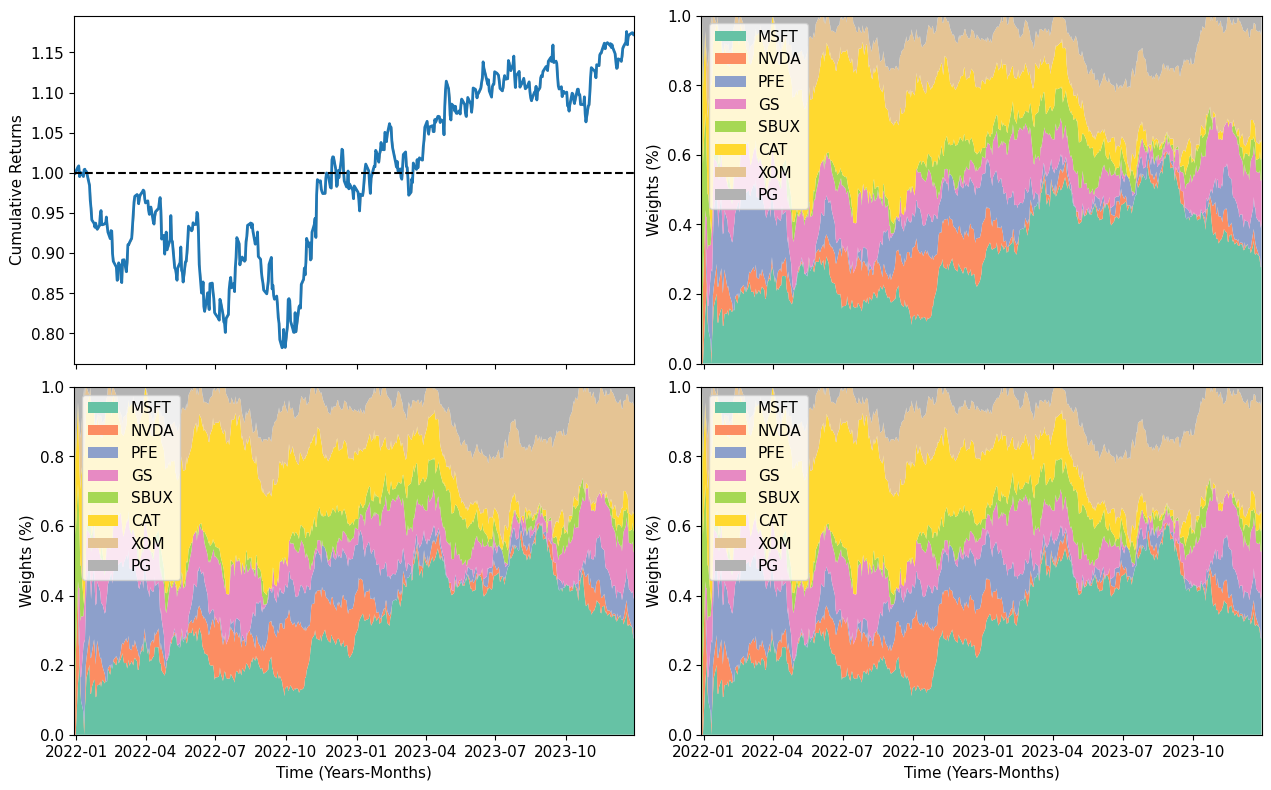

In [43]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_ppo_2_2, portfolio_weights_ppo_2_2, index, tickers)

### 2.2 A2C

In [44]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c_2_2 = np.zeros([runs, length])
portfolio_weights_a2c_2_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=a2c_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_a2c_2_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_a2c_2_2[i])
    print(check)

    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_2_2[i]),axis=1)
    Cumulative_returns_daily_drl_a2c_2_2[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  1.9166780352592467  minutes
504.0
Training time:  1.9400448123613994  minutes
504.0


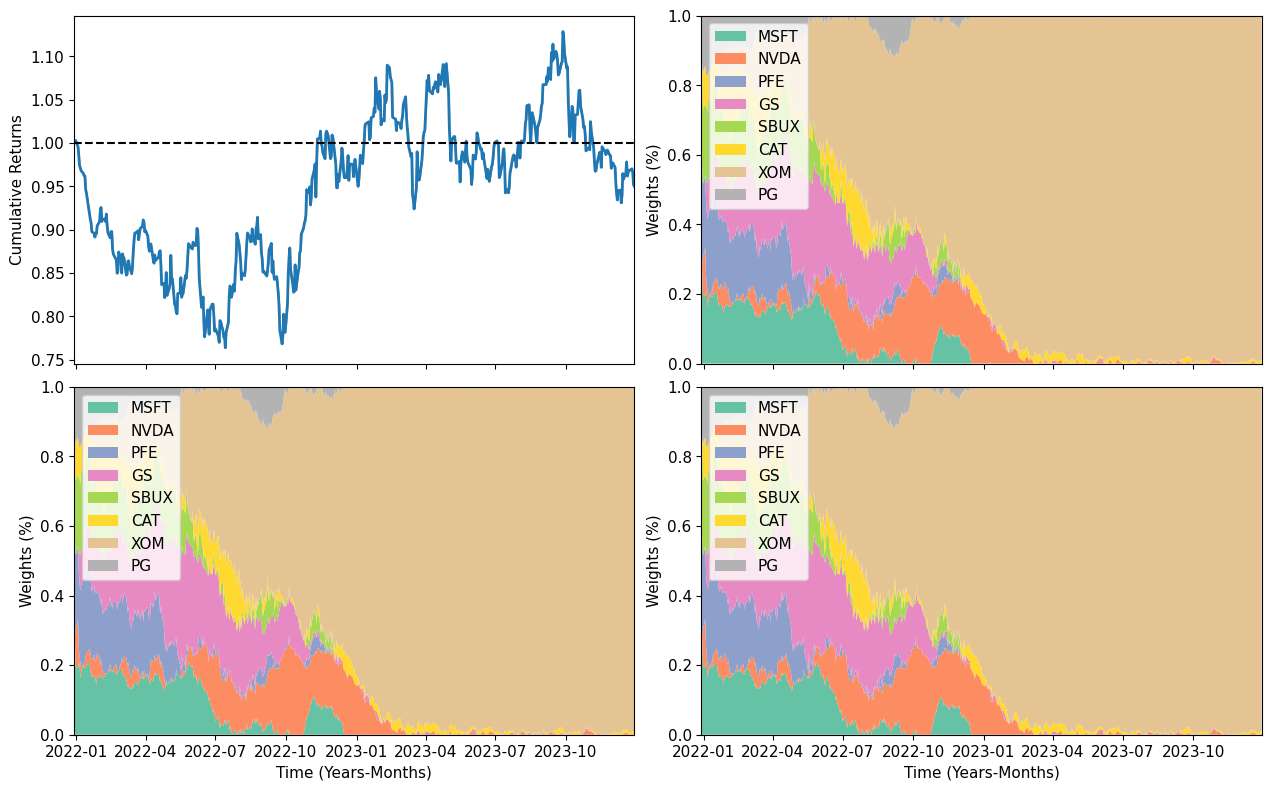

In [45]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_a2c_2_2, portfolio_weights_a2c_2_2, index, tickers)

### 2.3 SAC

In [46]:
algo = "SAC"
Cumulative_returns_daily_drl_sac_2_2 = np.zeros([runs, length])
portfolio_weights_sac_2_2 = np.zeros([runs, length, stocks])

i=0
while (i<runs):

    train_env = DummyVecEnv([lambda: SharpeEnv_S2(df = train_re_df, df_vix=data_train_VIX)])
    model = train(algo, policy, train_env, timesteps, save=False, hyperparams=sac_hyperparams)

    test_env = DummyVecEnv([lambda: SharpeEnv_S2(df = test_re_df, df_vix=data_test_VIX)])
    test_obs = test_env.reset()

    portfolio_weights_sac_2_2[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs, lookback=lookback))
    
    check = np.sum(portfolio_weights_sac_2_2[i])
    print(check)

    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_2_2[i]),axis=1)
    Cumulative_returns_daily_drl_sac_2_2[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  15.78067638874054  minutes
504.0
Training time:  11.633452745278676  minutes
504.0


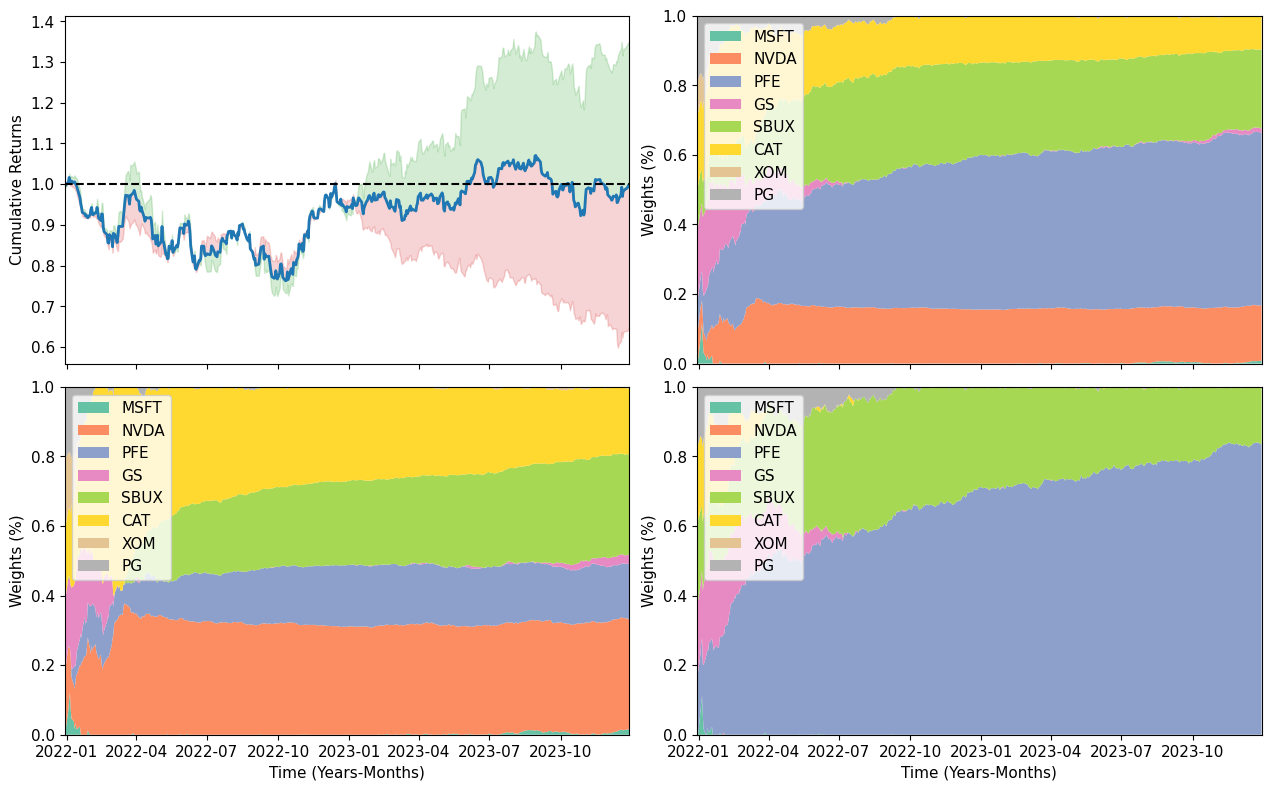

In [47]:
plot_cumulative_returns_and_weights(Cumulative_returns_daily_drl_sac_2_2, portfolio_weights_sac_2_2, index, tickers)

## Traditional approaches

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import riskfolio as rp

In [49]:
window = 60
start = len(train_re_df)-window
data = data.iloc[start:]
data = data.reset_index(drop=True)

In [50]:
data = data[tickers]
test_re_df = data_test.copy()

### Equal weighting

In [51]:
###Equal weighting###
portfolio_weights_equal = np.ones([test_re_df.shape[0],test_re_df.shape[1]])/test_re_df.shape[1]


In [52]:

###Maximum Sharpe Ratio###
portfolio_weights_max_S = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_max_S.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)
    
    try:
        weights = ef.max_sharpe(risk_free_rate=0.03)
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_max_S[idx]=np.array([weights[j] for j in tickers])
    idx +=1


In [53]:

###Minimum Volatility###
portfolio_weights_min_vol = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_vol.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)  
    weights = ef.min_volatility() 
   
    portfolio_weights_min_vol[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Calculate Cumulative Return

In [54]:
#Equal Weighting
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
Cumulative_returns_daily_equal = (1+return_stocks_equal).cumprod()
# Maximum Sharpe Ratio
return_stocks_max_S = np.sum(return_stocks.multiply(portfolio_weights_max_S),axis=1)
Cumulative_returns_daily_max_S = (1+return_stocks_max_S).cumprod()
# Minimum Volatility
return_stocks_min_vol = np.sum(return_stocks.multiply(portfolio_weights_min_vol),axis=1)
Cumulative_returns_daily_min_vol = (1+return_stocks_min_vol).cumprod()

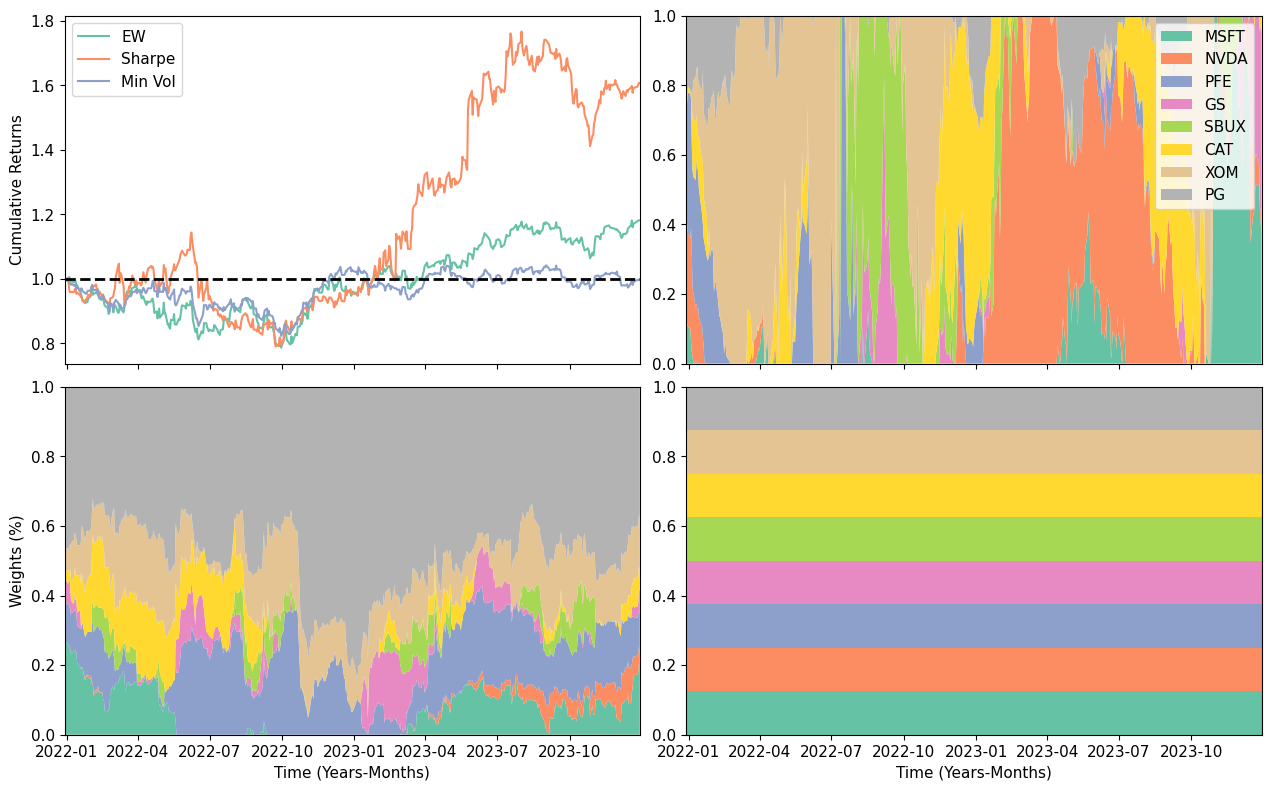

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(set_size(width='thesis', fraction=2)),constrained_layout=True, sharex=True)

axs[0, 0].plot(Cumulative_returns_daily_equal, label='EW')
axs[0, 0].plot(Cumulative_returns_daily_max_S, label='Sharpe')
axs[0, 0].plot(Cumulative_returns_daily_min_vol, label='Min Vol')
axs[0, 0].axhline(1, color='black', linestyle='--', lw=2)
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_ylabel("Cumulative Returns")

#Equal Weight
df = pd.DataFrame (portfolio_weights_max_S, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)

#Maximum Sharpe Ratio
df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_xlabel("Time (Years-Months)")
axs[1,0].set_ylabel("Weights (%)")

#Minimum Volatility
df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, *df.values.T)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_xlabel("Time (Years-Months)")

plt.show()

# Evaluation Metrics

In [56]:
import riskfolio as rp

In [57]:
def financial_metrics(daily_returns, risk_free_rate=0.03):

    annual_return = expected_returns.mean_historical_return(daily_returns, returns_data=True).values[0]

    # Calculate cumulative return
    cumulative_return = (1 + daily_returns).cumprod()[-1] - 1

    # Calculate volatility (annualized)
    volatility = np.std(daily_returns) * np.sqrt(252)

    # Calculate Sharpe Ratio
    sharpe_ratio = (annual_return - risk_free_rate) / volatility

    max_drawdown = rp.RiskFunctions.MDD_Abs(daily_returns)

    # Calculate Calmar Ratio
    calmar_ratio = annual_return / max_drawdown

    return {
        "Mean Annual Return": np.round(annual_return,4),
        "Cumulative Return": np.round(cumulative_return,4),
        "Volatility": np.round(volatility,4),
        "Sharpe Ratio": np.round(sharpe_ratio,4),
        "Calmar Ratio": np.round(calmar_ratio,4)
    }

In [58]:
def cumulative_to_simple_returns(cumulative_returns):
    simple_returns = []
    for i in range(1, len(cumulative_returns)):
        simple_return = cumulative_returns[i] / cumulative_returns[i - 1] - 1
        simple_returns.append(simple_return)
    return simple_returns

### Portfolio Return with Simple State

**PPO**

In [59]:
ppo_mean_1_1 = np.mean(np.array(Cumulative_returns_daily_drl_ppo_1_1),axis=0)
ppo_max_1_1 = np.array(Cumulative_returns_daily_drl_ppo_1_1[np.argmax(Cumulative_returns_daily_drl_ppo_1_1[:,-1])])
ppo_min_1_1 = np.array(Cumulative_returns_daily_drl_ppo_1_1[np.argmin(Cumulative_returns_daily_drl_ppo_1_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_mean_1_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_max_1_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_min_1_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0847
Cumulative Return  :  0.1763
Volatility  :  0.2051
Sharpe Ratio  :  0.2669
Calmar Ratio  :  0.3922
---Max Returns---
Mean Annual Return  :  0.1172
Cumulative Return  :  0.2475
Volatility  :  0.223
Sharpe Ratio  :  0.3909
Calmar Ratio  :  0.4396
---Min Returns---
Mean Annual Return  :  0.0513
Cumulative Return  :  0.105
Volatility  :  0.2
Sharpe Ratio  :  0.1065
Calmar Ratio  :  0.2831


**A2C**

In [60]:
a2c_mean_1_1 = np.mean(np.array(Cumulative_returns_daily_drl_a2c_1_1),axis=0)
a2c_max_1_1 = np.array(Cumulative_returns_daily_drl_a2c_1_1[np.argmax(Cumulative_returns_daily_drl_a2c_1_1[:,-1])])
a2c_min_1_1 = np.array(Cumulative_returns_daily_drl_a2c_1_1[np.argmin(Cumulative_returns_daily_drl_a2c_1_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_mean_1_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_max_1_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_min_1_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0633
Cumulative Return  :  0.1303
Volatility  :  0.2099
Sharpe Ratio  :  0.1585
Calmar Ratio  :  0.2685
---Max Returns---
Mean Annual Return  :  0.0633
Cumulative Return  :  0.1303
Volatility  :  0.2099
Sharpe Ratio  :  0.1585
Calmar Ratio  :  0.2685
---Min Returns---
Mean Annual Return  :  0.0633
Cumulative Return  :  0.1303
Volatility  :  0.2099
Sharpe Ratio  :  0.1585
Calmar Ratio  :  0.2685


**SAC**

In [61]:
sac_mean_1_1 = np.mean(np.array(Cumulative_returns_daily_drl_sac_1_1),axis=0)
sac_max_1_1 = np.array(Cumulative_returns_daily_drl_sac_1_1[np.argmax(Cumulative_returns_daily_drl_sac_1_1[:,-1])])
sac_min_1_1 = np.array(Cumulative_returns_daily_drl_sac_1_1[np.argmin(Cumulative_returns_daily_drl_sac_1_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_mean_1_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_max_1_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_min_1_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.1085
Cumulative Return  :  0.2282
Volatility  :  0.1767
Sharpe Ratio  :  0.444
Calmar Ratio  :  0.6502
---Max Returns---
Mean Annual Return  :  0.1313
Cumulative Return  :  0.2791
Volatility  :  0.1791
Sharpe Ratio  :  0.5654
Calmar Ratio  :  0.8664
---Min Returns---
Mean Annual Return  :  0.0852
Cumulative Return  :  0.1772
Volatility  :  0.1925
Sharpe Ratio  :  0.2866
Calmar Ratio  :  0.3335


### Sharpe Ratio with Simple State

**PPO**

In [62]:
ppo_mean_1_2 = np.mean(np.array(Cumulative_returns_daily_drl_ppo_1_2),axis=0)
ppo_max_1_2 = np.array(Cumulative_returns_daily_drl_ppo_1_2[np.argmax(Cumulative_returns_daily_drl_ppo_1_2[:,-1])])
ppo_min_1_2 = np.array(Cumulative_returns_daily_drl_ppo_1_2[np.argmin(Cumulative_returns_daily_drl_ppo_1_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_mean_1_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_max_1_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_min_1_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0348
Cumulative Return  :  0.0706
Volatility  :  0.1957
Sharpe Ratio  :  0.0244
Calmar Ratio  :  0.1542
---Max Returns---
Mean Annual Return  :  0.0348
Cumulative Return  :  0.0706
Volatility  :  0.1957
Sharpe Ratio  :  0.0244
Calmar Ratio  :  0.1542
---Min Returns---
Mean Annual Return  :  0.0348
Cumulative Return  :  0.0706
Volatility  :  0.1957
Sharpe Ratio  :  0.0244
Calmar Ratio  :  0.1542


**A2C**

In [63]:
a2c_mean_1_2 = np.mean(np.array(Cumulative_returns_daily_drl_a2c_1_2),axis=0)
a2c_max_1_2 = np.array(Cumulative_returns_daily_drl_a2c_1_2[np.argmax(Cumulative_returns_daily_drl_a2c_1_2[:,-1])])
a2c_min_1_2 = np.array(Cumulative_returns_daily_drl_a2c_1_2[np.argmin(Cumulative_returns_daily_drl_a2c_1_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_mean_1_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_max_1_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_min_1_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0848
Cumulative Return  :  0.1763
Volatility  :  0.2288
Sharpe Ratio  :  0.2393
Calmar Ratio  :  0.3848
---Max Returns---
Mean Annual Return  :  0.0848
Cumulative Return  :  0.1763
Volatility  :  0.2288
Sharpe Ratio  :  0.2393
Calmar Ratio  :  0.3848
---Min Returns---
Mean Annual Return  :  0.0848
Cumulative Return  :  0.1763
Volatility  :  0.2288
Sharpe Ratio  :  0.2393
Calmar Ratio  :  0.3848


**SAC**

In [64]:
sac_mean_1_2 = np.mean(np.array(Cumulative_returns_daily_drl_sac_1_2),axis=0)
sac_max_1_2 = np.array(Cumulative_returns_daily_drl_sac_1_2[np.argmax(Cumulative_returns_daily_drl_sac_1_2[:,-1])])
sac_min_1_2 = np.array(Cumulative_returns_daily_drl_sac_1_2[np.argmin(Cumulative_returns_daily_drl_sac_1_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_mean_1_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_max_1_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_min_1_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.1856
Cumulative Return  :  0.4048
Volatility  :  0.2965
Sharpe Ratio  :  0.5248
Calmar Ratio  :  0.4758
---Max Returns---
Mean Annual Return  :  0.3552
Cumulative Return  :  0.8343
Volatility  :  0.4546
Sharpe Ratio  :  0.7153
Calmar Ratio  :  0.6252
---Min Returns---
Mean Annual Return  :  -0.0125
Cumulative Return  :  -0.0248
Volatility  :  0.1963
Sharpe Ratio  :  -0.2164
Calmar Ratio  :  -0.0397


### Portfolio Return with Complex State

**PPO**

In [65]:
ppo_mean_2_1 = np.mean(np.array(Cumulative_returns_daily_drl_ppo_2_1),axis=0)
ppo_max_2_1 = np.array(Cumulative_returns_daily_drl_ppo_2_1[np.argmax(Cumulative_returns_daily_drl_ppo_2_1[:,-1])])
ppo_min_2_1 = np.array(Cumulative_returns_daily_drl_ppo_2_1[np.argmin(Cumulative_returns_daily_drl_ppo_2_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_mean_2_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_max_2_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_min_2_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.1458
Cumulative Return  :  0.312
Volatility  :  0.2424
Sharpe Ratio  :  0.4774
Calmar Ratio  :  0.5503
---Max Returns---
Mean Annual Return  :  0.149
Cumulative Return  :  0.3195
Volatility  :  0.2468
Sharpe Ratio  :  0.4823
Calmar Ratio  :  0.5492
---Min Returns---
Mean Annual Return  :  0.1425
Cumulative Return  :  0.3046
Volatility  :  0.239
Sharpe Ratio  :  0.4706
Calmar Ratio  :  0.5514


**A2C**

In [66]:
a2c_mean_2_1 = np.mean(np.array(Cumulative_returns_daily_drl_a2c_2_1),axis=0)
a2c_max_2_1 = np.array(Cumulative_returns_daily_drl_a2c_2_1[np.argmax(Cumulative_returns_daily_drl_a2c_2_1[:,-1])])
a2c_min_2_1 = np.array(Cumulative_returns_daily_drl_a2c_2_1[np.argmin(Cumulative_returns_daily_drl_a2c_2_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_mean_2_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_max_2_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_min_2_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.094
Cumulative Return  :  0.1964
Volatility  :  0.2026
Sharpe Ratio  :  0.3158
Calmar Ratio  :  0.3961
---Max Returns---
Mean Annual Return  :  0.1192
Cumulative Return  :  0.2521
Volatility  :  0.2303
Sharpe Ratio  :  0.3873
Calmar Ratio  :  0.372
---Min Returns---
Mean Annual Return  :  0.0682
Cumulative Return  :  0.1408
Volatility  :  0.188
Sharpe Ratio  :  0.2032
Calmar Ratio  :  0.3327


**SAC**

In [67]:
sac_mean_2_1 = np.mean(np.array(Cumulative_returns_daily_drl_sac_2_1),axis=0)
sac_max_2_1 = np.array(Cumulative_returns_daily_drl_sac_2_1[np.argmax(Cumulative_returns_daily_drl_sac_2_1[:,-1])])
sac_min_2_1 = np.array(Cumulative_returns_daily_drl_sac_2_1[np.argmin(Cumulative_returns_daily_drl_sac_2_1[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_mean_2_1))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_max_2_1))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_min_2_1))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0784
Cumulative Return  :  0.1625
Volatility  :  0.2165
Sharpe Ratio  :  0.2235
Calmar Ratio  :  0.2872
---Max Returns---
Mean Annual Return  :  0.1476
Cumulative Return  :  0.3163
Volatility  :  0.2569
Sharpe Ratio  :  0.4578
Calmar Ratio  :  0.4962
---Min Returns---
Mean Annual Return  :  0.0044
Cumulative Return  :  0.0088
Volatility  :  0.1959
Sharpe Ratio  :  -0.1307
Calmar Ratio  :  0.0161


### Sharpe Ratio with Complex State

**PPO**

In [68]:
ppo_mean_2_2 = np.mean(np.array(Cumulative_returns_daily_drl_ppo_2_2),axis=0)
ppo_max_2_2 = np.array(Cumulative_returns_daily_drl_ppo_2_2[np.argmax(Cumulative_returns_daily_drl_ppo_2_2[:,-1])])
ppo_min_2_2 = np.array(Cumulative_returns_daily_drl_ppo_2_2[np.argmin(Cumulative_returns_daily_drl_ppo_2_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_mean_2_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_max_2_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_min_2_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0826
Cumulative Return  :  0.1717
Volatility  :  0.212
Sharpe Ratio  :  0.2482
Calmar Ratio  :  0.3558
---Max Returns---
Mean Annual Return  :  0.0826
Cumulative Return  :  0.1717
Volatility  :  0.212
Sharpe Ratio  :  0.2482
Calmar Ratio  :  0.3558
---Min Returns---
Mean Annual Return  :  0.0826
Cumulative Return  :  0.1717
Volatility  :  0.212
Sharpe Ratio  :  0.2482
Calmar Ratio  :  0.3558


**A2C**

In [69]:
a2c_mean_2_2 = np.mean(np.array(Cumulative_returns_daily_drl_a2c_2_2),axis=0)
a2c_max_2_2 = np.array(Cumulative_returns_daily_drl_a2c_2_2[np.argmax(Cumulative_returns_daily_drl_a2c_2_2[:,-1])])
a2c_min_2_2 = np.array(Cumulative_returns_daily_drl_a2c_2_2[np.argmin(Cumulative_returns_daily_drl_a2c_2_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_mean_2_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_max_2_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_min_2_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  -0.0254
Cumulative Return  :  -0.0502
Volatility  :  0.257
Sharpe Ratio  :  -0.2158
Calmar Ratio  :  -0.0991
---Max Returns---
Mean Annual Return  :  -0.0254
Cumulative Return  :  -0.0502
Volatility  :  0.257
Sharpe Ratio  :  -0.2158
Calmar Ratio  :  -0.0991
---Min Returns---
Mean Annual Return  :  -0.0254
Cumulative Return  :  -0.0502
Volatility  :  0.257
Sharpe Ratio  :  -0.2158
Calmar Ratio  :  -0.0991


**SAC**

In [70]:
sac_mean_2_2 = np.mean(np.array(Cumulative_returns_daily_drl_sac_2_2),axis=0)
sac_max_2_2 = np.array(Cumulative_returns_daily_drl_sac_2_2[np.argmax(Cumulative_returns_daily_drl_sac_2_2[:,-1])])
sac_min_2_2 = np.array(Cumulative_returns_daily_drl_sac_2_2[np.argmin(Cumulative_returns_daily_drl_sac_2_2[:,-1])])


print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_mean_2_2))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_max_2_2))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_min_2_2))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  -0.0012
Cumulative Return  :  -0.0024
Volatility  :  0.2206
Sharpe Ratio  :  -0.1414
Calmar Ratio  :  -0.0045
---Max Returns---
Mean Annual Return  :  0.1616
Cumulative Return  :  0.3486
Volatility  :  0.2776
Sharpe Ratio  :  0.4741
Calmar Ratio  :  0.4685
---Min Returns---
Mean Annual Return  :  -0.1962
Cumulative Return  :  -0.3533
Volatility  :  0.2108
Sharpe Ratio  :  -1.0728
Calmar Ratio  :  -0.3881


### Traditional Models

**Equal Weight**

In [71]:
for key, value in financial_metrics(return_stocks_equal).items():
    print(key, ' : ', value)

Mean Annual Return  :  0.0868
Cumulative Return  :  0.1811
Volatility  :  0.2025
Sharpe Ratio  :  0.2804
Calmar Ratio  :  0.3865


**Sharpe Ratio**

In [72]:
for key, value in financial_metrics(return_stocks_max_S).items():
    print(key, ' : ', value)

Mean Annual Return  :  0.2676
Cumulative Return  :  0.6067
Volatility  :  0.3129
Sharpe Ratio  :  0.7591
Calmar Ratio  :  0.7579


**Min Volatility**

In [73]:
for key, value in financial_metrics(return_stocks_min_vol).items():
    print(key, ' : ', value)

Mean Annual Return  :  -0.0012
Cumulative Return  :  -0.0024
Volatility  :  0.1562
Sharpe Ratio  :  -0.1998
Calmar Ratio  :  -0.0066


## Plotting all cumulative returns together

**Max Results**

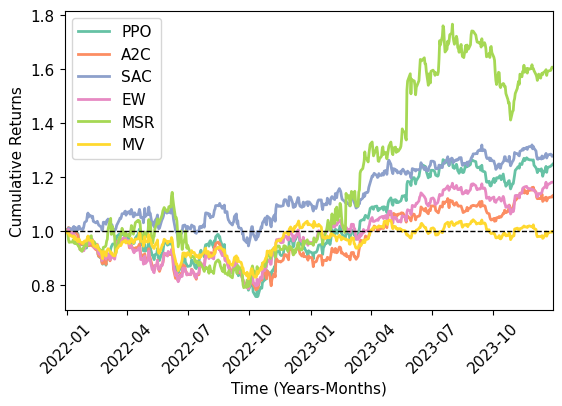

In [74]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_max_1_1, label='PPO', linewidth =2.0)
ax.plot(x, a2c_max_1_1, label='A2C', linewidth =2.0)
ax.plot(x, sac_max_1_1, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="EW", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="MSR", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="MV", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
ax.legend()

plt.show()

**Min Results**

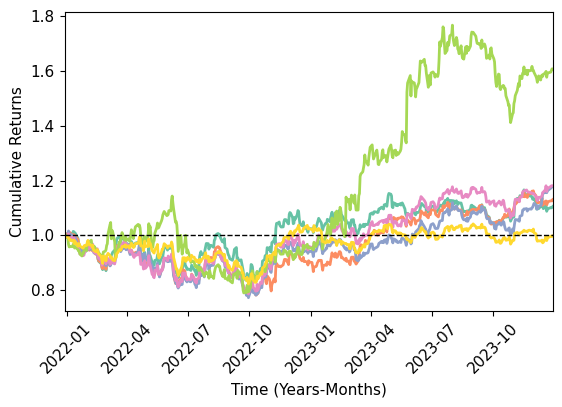

In [75]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_min_1_1, label='PPO', linewidth =2.0)
ax.plot(x, a2c_min_1_1, label='A2C', linewidth =2.0)
ax.plot(x, sac_min_1_1, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="Equal Weight", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="Tangent Portfolio", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="Minimum Volatility", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
#ax.legend()

plt.show()

**Mean Results**

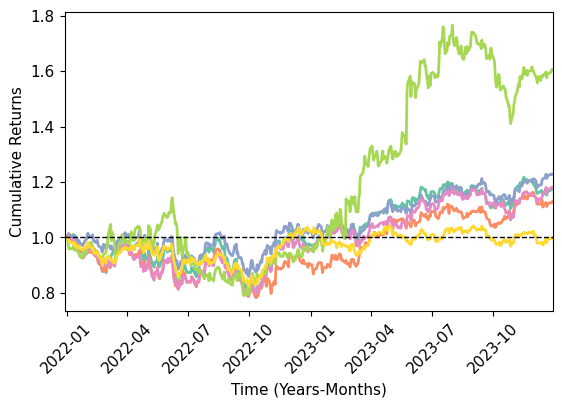

In [76]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_mean_1_1, label='PPO', linewidth =2.0)
ax.plot(x, a2c_mean_1_1, label='A2C', linewidth =2.0)
ax.plot(x, sac_mean_1_1, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="Equal Weight", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="Tangent Portfolio", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="Minimum Volatility", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
#ax.legend()

plt.show()